In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
raw_data_path=os.path.join('data','raw')
df=pd.read_csv(os.path.join(raw_data_path,'fer2013.csv'))
X=[]
for i in range(len(df)):
    X.append(df.loc[i,'pixels'].split(' '))
X=np.array(X,np.float32)/255.
y=df.emotion.values
X_train=X[np.where(df.Usage=='Training')]
y_train=y[np.where((df.Usage=='Training'))]
X_test=X[np.where((df.Usage!='Training'))]
y_test=y[np.where((df.Usage!='Training'))]
def balance_classes(X,y):
    X1=X[np.where(y!=1)]
    X2=X[np.where(y==1)]
    X2=np.repeat(X2,9,axis=0)
    X=np.concatenate((X1,X2),axis=0)
    y1=y[np.where(y!=1)]
    y2=y[np.where(y==1)]
    y2=np.repeat(y2,9,axis=0)
    y=np.concatenate((y1,y2),axis=0)
    i=[i for i in range(len(y))]
    np.random.shuffle(i)
    return X[i],y[i]
X_train,y_train=balance_classes(X_train,y_train)
def one_hot_encoder(X):
    N=len(X)
    K=len(set(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=X[i]
        Z[i,c]=1
    return Z

In [2]:
X_train.shape

(32197, 2304)

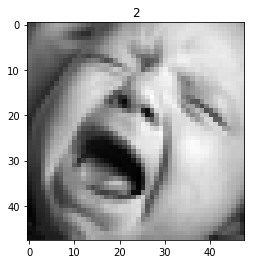

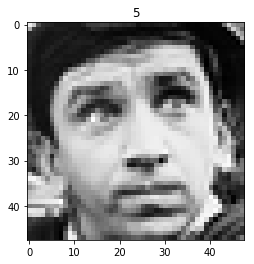

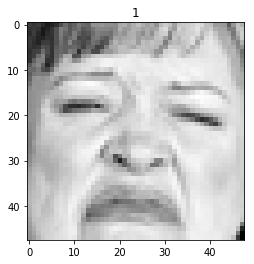

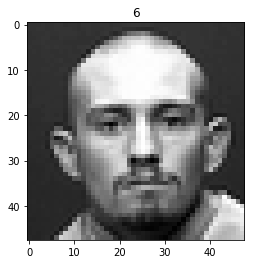

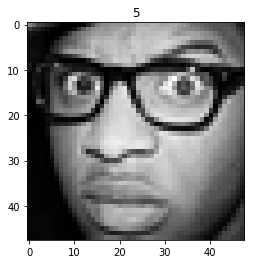

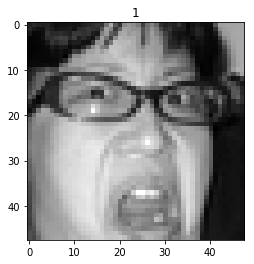

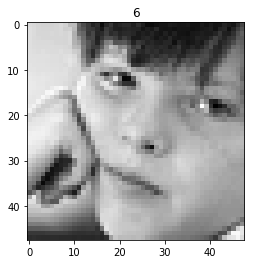

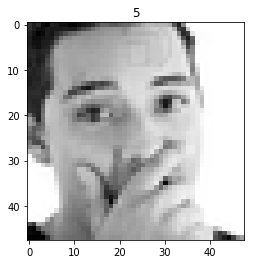

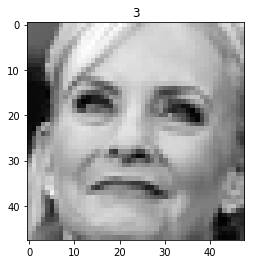

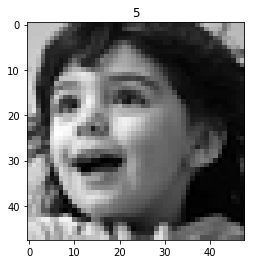

In [3]:
for i in range(10):
    plt.imshow(X_train[i].reshape(48,48),cmap='gray')
    plt.title(y_train[i])
    plt.show()

In [4]:
import tensorflow as tf

C:\Users\ytnvj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
class HiddenLayer(object):
    def __init__(self,i,M1,M2,af='relu',rs=None):
        self.id=i
        self.M1=M1
        self.M2=M2
        self.af=af
        self.W=tf.Variable(tf.random_normal(shape=[M1,M2],stddev=np.sqrt(M1),seed=rs,dtype=tf.float32))
        self.b=tf.Variable(tf.random_normal(shape=[M2],seed=rs,dtype=tf.float32))
        self.params=[self.W,self.b]
        
    def forward(self,X):
        if self.af=='tanh':
            return tf.nn.tanh(tf.matmul(X,self.W)+self.b)
        if self.af=='sigmoid':
            return tf.nn.sigmoid(tf.matmul(X,self.W)+self.b)
        if self.af=='relu':
            return tf.nn.relu(tf.matmul(X,self.W)+self.b)
        if self.af=='leaky-relu':
            return tf.nn.leaky_relu(tf.matmul(X,self.W)+self.b)

In [150]:
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5,af='relu', poolsz=(2, 2)):
        # mi = input feature map size
        # mo = output feature map size
        sz = (fw, fh, mi, mo)
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        self.af=af
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize=[1, p1, p2, 1],
            strides=[1, p1, p2, 1],
            padding='SAME'
        )
        if self.af=='tanh':
            return tf.nn.tanh(pool_out)
        if self.af=='sigmoid':
            return tf.nn.sigmoid(pool_out)
        if self.af=='relu':
            return tf.nn.relu(pool_out)
        if self.af=='leaky-relu':
            return tf.nn.leaky_relu(pool_out)


In [212]:
class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, lr=1e-4, mu=0.99, reg=1e-3, decay=0.99999, eps=1e-10, batch_sz=100, epochs=10, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = one_hot_encoder(Y).astype(np.float32)

        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate

        # initialize convpool layers
        N, width, height, c = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo, fw, fh,af in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi, mo, fw, fh,af)
            self.convpool_layers.append(layer)
            outw = outw // 2
            outh = outh // 2
            mi = mo

        # initialize mlp layers
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2,af in self.hidden_layer_sizes:
            h = HiddenLayer(count,M1, M2,af)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params

        # set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, width, height, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=act,
                labels=tfY
            )
        ) + rcost
        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
#         train_op = tf.train.AdamOptimizer(lr, beta1=decay, beta2=mu,epsilon=eps).minimize(cost)


        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)


In [213]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5,'relu'),(50, 5, 5,'leaky-relu')],
    hidden_layer_sizes=[(500,'tanh'),(100,'relu')],
)


In [214]:
from sklearn.utils import shuffle

In [215]:
n_x=X_train.reshape(32197,48,48,1)

In [216]:
def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)
def error_rate(targets, predictions):
    return np.mean(targets == predictions)

i: 0 j: 0 nb: 311 cost: 12978457.0 error rate: 0.144
i: 0 j: 20 nb: 311 cost: 12977747.0 error rate: 0.148
i: 0 j: 40 nb: 311 cost: 12976506.0 error rate: 0.122
i: 0 j: 60 nb: 311 cost: 12974467.0 error rate: 0.174
i: 0 j: 80 nb: 311 cost: 12971815.0 error rate: 0.183
i: 0 j: 100 nb: 311 cost: 12968698.0 error rate: 0.213
i: 0 j: 120 nb: 311 cost: 12965160.0 error rate: 0.193
i: 0 j: 140 nb: 311 cost: 12961377.0 error rate: 0.152
i: 0 j: 160 nb: 311 cost: 12957316.0 error rate: 0.19
i: 0 j: 180 nb: 311 cost: 12952979.0 error rate: 0.182
i: 0 j: 200 nb: 311 cost: 12948554.0 error rate: 0.179
i: 0 j: 220 nb: 311 cost: 12943919.0 error rate: 0.166
i: 0 j: 240 nb: 311 cost: 12939158.0 error rate: 0.17
i: 0 j: 260 nb: 311 cost: 12934350.0 error rate: 0.186
i: 0 j: 280 nb: 311 cost: 12929525.0 error rate: 0.193
i: 0 j: 300 nb: 311 cost: 12924586.0 error rate: 0.159
i: 1 j: 0 nb: 311 cost: 12921912.0 error rate: 0.136
i: 1 j: 20 nb: 311 cost: 12916890.0 error rate: 0.185
i: 1 j: 40 nb: 311 co

i: 9 j: 140 nb: 311 cost: 12257478.0 error rate: 0.236
i: 9 j: 160 nb: 311 cost: 12252528.0 error rate: 0.199
i: 9 j: 180 nb: 311 cost: 12247570.0 error rate: 0.181
i: 9 j: 200 nb: 311 cost: 12242615.0 error rate: 0.159
i: 9 j: 220 nb: 311 cost: 12237664.0 error rate: 0.167
i: 9 j: 240 nb: 311 cost: 12232701.0 error rate: 0.195
i: 9 j: 260 nb: 311 cost: 12227750.0 error rate: 0.182
i: 9 j: 280 nb: 311 cost: 12222802.0 error rate: 0.192
i: 9 j: 300 nb: 311 cost: 12217856.0 error rate: 0.194


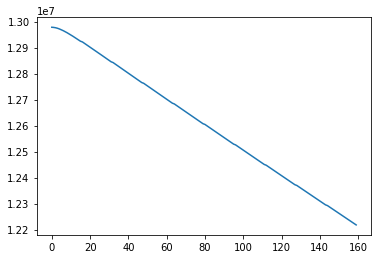

In [217]:
model.fit(n_x, y_train)

In [ ]:
def init_filter(shape,poolsz):
    w=np.random.randn(*shape)/np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz)))
    return w.astype(np.float32)
class ConvPoolLayer(object):
    def __init__(self,i,M1,M2,fw=5,fh=5,poolsz=(2,2),af='relu',rs=None):
        self.id=i
        self.M1=M1
        self.M2=M2
        shape=[fw,fh,M1,M2]
        self.af=af
        self.W=tf.Variable(tf.random_normal(shape=[fw,fh,M1,M2],stddev=np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz))),seed=rs,dtype=tf.float32))
        self.b=tf.Variable(tf.zeros(shape=[M2],seed=rs,dtype=tf.float32))
        self.poolsz=poolsz
        self.params=[self.W,self.b]
    def forward(self,X):
        